In [2]:
%pylab inline
import pandas as pd
import seaborn as sns
from scipy import linalg

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Load data
genes = pd.read_csv('gene_expression_s.csv', index_col=0).sort_index(0).sort_index(1)

sample_data = pd.read_csv('sample_info_qc.csv', index_col=0).sort_index(0).sort_index(1)
sample_data = sample_data.ix[sample_data["Pass QC"]]

genes = genes.ix[:, sample_data.index]

# Rescale data without ERCC's
ercc_idx = filter(lambda i: 'ERCC' in i, genes.index)

egenes = genes.drop(ercc_idx)
egenes = egenes.drop('GFP')
egenes = (egenes / egenes.sum()) * 1e6

# Load gene annotations
gene_annotation = pd.read_csv('zv9_gene_annotation.txt', sep='\t', index_col=0)
gene_annotation = gene_annotation.ix[egenes.index]

We got a list of the Ohnologs used in the Zebgrafish genome assembly paper from Camille Bethelot

The genes are from ENSEMBL 63. It should still be fairly comparable in terms of gene annotation from now to then.

In [4]:
# Load Ohnologs
ohnopairs = pd.read_table('ohnopairs_zebrafish_ensembl63.txt')

In [5]:
# Focus on only Ohnolog _pairs_
mask1 = ohnopairs['ohnolog_1'].map(lambda s: len(s.split(' '))) == 1
mask2 = ohnopairs['ohnolog_2'].map(lambda s: len(s.split(' '))) == 1

mask = mask1 & mask2

In [6]:
ohnopairs = ohnopairs[mask]

In [7]:
un_annot = set(ohnopairs.ohnolog_1).difference(gene_annotation.index)
ohnopairs = ohnopairs[(~ohnopairs.ohnolog_1.map(un_annot.__contains__))]

un_annot = set(ohnopairs.ohnolog_2).difference(gene_annotation.index)
ohnopairs = ohnopairs[(~ohnopairs.ohnolog_2.map(un_annot.__contains__))]

In [8]:
ohnopairs.index = ohnopairs.ohnolog_1

In [9]:
# Let's use log transformed expression throughout
logexp = np.log10(egenes + 1)

In [10]:
# Look at binary expression patterns in Ohnolog pairs

ohno_bin = pd.DataFrame(index=ohnopairs.index)

ohno_bin['c00'] = 0
ohno_bin['c01'] = 0
ohno_bin['c10'] = 0
ohno_bin['c11'] = 0

for g in ohnopairs.index:
    pair = ohnopairs.ix[g]
    oh1 = logexp.ix[pair['ohnolog_1']] > np.log10(1 + 1)
    oh2 = logexp.ix[pair['ohnolog_2']] > np.log10(1 + 1)
    
    c11 = (oh1 & oh2).sum()
    ohno_bin.ix[g, 'c11'] = c11
    ohno_bin.ix[g, 'c10'] = oh1.sum() - c11
    ohno_bin.ix[g, 'c01'] = oh2.sum() - c11
    ohno_bin.ix[g, 'c00'] = len(oh1) - (oh1 ^ oh2).sum()

In [12]:
# Find a value for smallest of uniquely expressed gene in a given Ohnolog pair
ohno_bin['min_c01c10'] = ohno_bin[['c01', 'c10']].min(1)

In [13]:
# We want to compare the number of cells where both genes in
# a pair are expressed (c11) to the number of cells where 
# only one if either gene is used exclusively.

ohno_bin['both_min_diff'] = ohno_bin['min_c01c10'] - ohno_bin['c11']
ohno_bin['both_min_diff'].sort(inplace=False, ascending=False).head()

# A high value of this measure means very XOR like beahvior,
# while a low value means both genes in a pair are expressed 
# most of the time.

ohnolog_1
ENSDARG00000044183    50
ENSDARG00000017653    46
ENSDARG00000088440    44
ENSDARG00000061108    44
ENSDARG00000032469    43
Name: both_min_diff, dtype: int64

In [14]:
# For a pair we want to look at the difference between a
# gene uniquely expressed in many cells to the other gene,
# being expressed in fewer cells.

ohno_bin['exclusive'] = list(ohno_bin[['c01', 'c10']].max(1) - ohno_bin[['c01', 'c10']].min(1))

# A high value of this indicates only one gene in a pair is
# predominately used.

In [15]:
# For convenience, put in gene names in the binary expression pattern table.

ohno_bin['name'] = gene_annotation.ix[ohno_bin.index, 'Associated Gene Name']

In [16]:
# Now we formulate the taxnonomy of the Ohnolog pairs
# in to categories by a decision tree on the binary
# expression features

ohno_bin['category'] = 'Mixed Ohnolog'

for g in ohno_bin.index:
    if ohno_bin.ix[g, 'c00'] > 300:
        ohno_bin.ix[g, 'category'] = 'Not expressed'
        continue
    
    if ohno_bin.ix[g, 'both_min_diff'] > 15:
        ohno_bin.ix[g, 'category'] = 'XOR Ohnolog'
        continue

    if ohno_bin.ix[g, 'exclusive'] > 60:
        ohno_bin.ix[g, 'category'] = 'Single Ohnolog'
        continue

In [17]:
ohno_bin['category'].value_counts()

Not expressed     2107
Single Ohnolog     430
Mixed Ohnolog      220
XOR Ohnolog        177
dtype: int64

Takeaways:

- Most genes are not expressed enough for us to say anything about Ohnolog use
- Majority of expressed genes primarily use one of the genes in the Ohnolog pair
- For Ohnologs which use both genes in the pair, hardly any have correlated expression
- There are interesting XOR Ohnolog pairs

For the sake if illustration, let's illustrate how we perform the taxonomical splits.

In [22]:
# Give some colors to the classes
colorer = {
    'Not expressed': (1,1,1,1),
    'XOR Ohnolog': cm.Set2(0),
    'Single Ohnolog': cm.Set2(0.33),
    'Mixed Ohnolog': cm.Set2(0.99)
    }

In [23]:
# For convenience, put  the color in the table
ohno_bin['color'] = ohno_bin['category'].map(colorer.__getitem__)

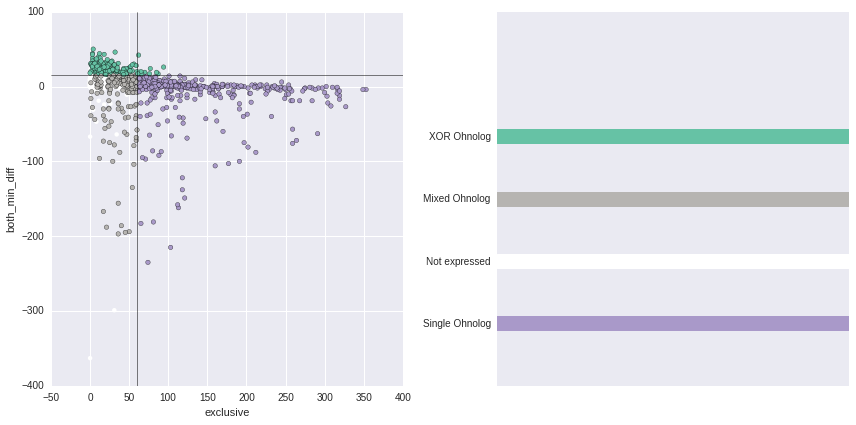

In [27]:
figsize(12, 6)

plt.subplot(1, 2, 1)

# Plot unexpressed before expressed so we don't
# cover the expressed pairs with unexpressed pairs.

idx = ohno_bin.query('category == "Not expressed"').index
plt.scatter(ohno_bin.ix[idx, 'exclusive'],
            ohno_bin.ix[idx, 'both_min_diff'],
            color=ohno_bin.ix[idx, 'color'], edgecolor='none')

idx = ohno_bin.query('category != "Not expressed"').index
plt.scatter(ohno_bin.ix[idx, 'exclusive'],
            ohno_bin.ix[idx, 'both_min_diff'],
            color=ohno_bin.ix[idx, 'color'], edgecolor='k')

plt.axvline(60, c='k', lw=0.5);
plt.axhline(15, c='k', lw=0.5);
sns.axlabel('exclusive', 'both_min_diff');

# Make a legend
plt.subplot(1, 2, 2)

labs = []
locs = []
for i, cat in enumerate(colorer):
    plt.plot([0, 1], [i, i], color=colorer[cat], lw=15)
    locs.append(i)
    labs.append(cat)

plt.ylim(-1, 5);
plt.yticks(locs, labs);
plt.xticks([]);

plt.tight_layout();

In [28]:
# Plot example pairs from the different categories

In [29]:
sns.set_style('white');

In [30]:
sample_data.head()

,% Parent,% Total,3'UTR_Exons,488,5'UTR_Exons,561,Average mapped length,CDS_Exons,Cells,ERCC Content,...,log_detection_limit,log_total_molecules,lower_tpm_limit,molecule_r2,outlier_component,total_molecules,tsne_0,tsne_1,within_large_component,within_small_component
Well,,,,,,,,,,,,,,,,,,,,,
DIM_1_A1,NaN,100.00%,615178,80,118167,6,229.53,1273306,1,116339.14620,...,2.450692,6.460057,38.688781,0.849279,-0.119395,2884413,-0.357368,12.650468,0.070390,-0.104144
DIM_1_A10,NaN,100.00%,625664,39,99645,1,230.31,1032911,1,279412.04190,...,2.450692,5.900172,286.543062,0.853730,0.017293,794642,-0.001426,6.763604,0.073285,0.020246
DIM_1_A11,NaN,100.00%,733798,53,245374,1,230.64,3031565,1,24324.44224,...,2.450692,6.978323,19.049522,0.778746,-0.036702,9513110,-8.698019,8.706809,-0.016871,-0.179175
DIM_1_A12,NaN,100.00%,827658,337,148061,9,230.22,1597099,1,186802.23200,...,2.450692,6.094479,190.479102,0.901161,0.034679,1243023,-4.495216,11.184408,0.045065,-0.065027
DIM_1_A2,NaN,100.00%,187244,83,38552,5,229.60,322876,1,251667.90200,...,2.751722,5.955462,388.363168,0.817718,0.072677,902531,-1.362267,3.037966,0.074522,0.049654


In [31]:
from ast import literal_eval

In [32]:
sample_data.cluster_color = sample_data.cluster_color.apply(literal_eval)

In [67]:
def plot_pair(xg='ENSDARG00000077760', yg='ENSDARG00000073971'):
    
    xe = np.log10(egenes[sample_data.index].ix[xg] + 1)
    ye = np.log10(egenes[sample_data.index].ix[yg] + 1)
    
    mask = xe.where(xe < 0.001).index
    xe[mask] += np.random.uniform(-0.4, -0.1, size=mask.shape)

    mask = ye.where(ye < 0.001).index
    ye[mask] += np.random.uniform(-0.4, -0.1, size=mask.shape)
    
    plt.scatter(xe,
                ye,
                color=sample_data['cluster_color'],
                s=100,
                edgecolor='k')
    
    plt.axhline(0, c='grey', linestyle='--')
    plt.axvline(0, c='grey', linestyle='--')

    sns.axlabel(gene_annotation['Associated Gene Name'][xg] + ' (log10 TPM)',
                gene_annotation['Associated Gene Name'][yg] + ' (log10 TPM)')
    
    plt.xlim(-0.5, 4.1);
    plt.ylim(-0.5, 4.1);

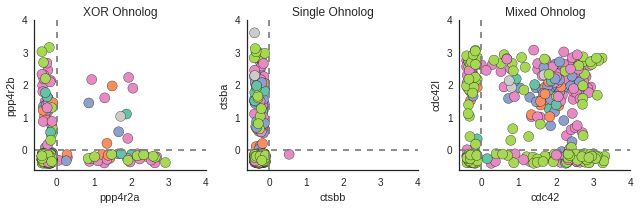

In [80]:
figsize(9, 3)
example_pairs = []
np.random.seed(1221)
for i, example in enumerate(['ENSDARG00000026540', 'ENSDARG00000067570', 'ENSDARG00000044573']):
    
    plt.subplot(1, 3, i + 1)
    pair = ohnopairs.ix[example]
    example_pairs.append(pair)
    plot_pair(pair.ohnolog_1, pair.ohnolog_2)

    plt.title(ohno_bin.ix[example, 'category'])
    plt.xlabel(gene_annotation['Associated Gene Name'][pair['ohnolog_1']])
    plt.ylabel(gene_annotation['Associated Gene Name'][pair['ohnolog_2']])

    plt.xlim(-0.6, 4)
    plt.ylim(-0.6, 4)
    
sns.despine()
plt.tight_layout();
plt.savefig('figures/ohnolog_taxa_examples.pdf');

In [83]:
ohno_bin.columns

Index([u'c00', u'c01', u'c10', u'c11', u'min_c01c10', u'both_min_diff', u'exclusive', u'name', u'category', u'color'], dtype='object')

In [ ]:
[['name', 'category', 'c00', 'c01', 'c10', 'c11', 'both_min_diff', 'exclusive']]

In [111]:
combined = \
ohno_bin.query('category != "Not expressed"') \
        .sort('category') \
        .rename(columns={'name': 'name_1'})

combined['id_2'] = ohnopairs.ix[combined.index, 'ohnolog_2']
combined['name_2'] = list(gene_annotation.ix[combined['id_2'], 'Associated Gene Name'])

combined[['name_1', 'id_2', 'name_2',
          'category', 'c00', 'c01', 'c10', 'c11',
          'both_min_diff', 'exclusive']] \
        .to_csv('table3-ohnolog-classes.csv')

In [112]:
pwd

u'/nfs/research2/teichmann/valentine/CVEJIC-CD41'

In [94]:
combined.head()

,name_1,category,c00,c01,c10,c11,both_min_diff,exclusive
ohnolog_1,,,,,,,,
ENSDARG00000019596,NRD1 (1 of 2),Mixed Ohnolog,288,8,67,6,2,59
ENSDARG00000030155,ssbp3b,Mixed Ohnolog,268,27,68,17,10,41
ENSDARG00000063182,RC3H1 (2 of 2),Mixed Ohnolog,275,32,56,24,8,24
ENSDARG00000011334,ncaldb,Mixed Ohnolog,281,55,27,16,11,28
ENSDARG00000017235,eif5a,Mixed Ohnolog,273,25,65,211,-186,40


In [89]:
ohno_bin.query('category != "Not expressed"') \
        .sort('category')[['name', 'category', 'c00', 'c01', 'c10', 'c11', 'both_min_diff', 'exclusive']] \
        .head()

,name,category,c00,c01,c10,c11,both_min_diff,exclusive
ohnolog_1,,,,,,,,
ENSDARG00000019596,NRD1 (1 of 2),Mixed Ohnolog,288,8,67,6,2,59
ENSDARG00000030155,ssbp3b,Mixed Ohnolog,268,27,68,17,10,41
ENSDARG00000063182,RC3H1 (2 of 2),Mixed Ohnolog,275,32,56,24,8,24
ENSDARG00000011334,ncaldb,Mixed Ohnolog,281,55,27,16,11,28
ENSDARG00000017235,eif5a,Mixed Ohnolog,273,25,65,211,-186,40


In [184]:
# Just check some functional enrichment

In [167]:
from gprofiler import gprofiler

In [185]:
query = list(ohno_bin.query("category == 'XOR Ohnolog'").index)
result = gprofiler(query, organism='drerio')
result.sort('p.value')[['term.name', 'p.value']]

,term.name,p.value
term.id,,
GO:0043412,macromolecule modification,0.00204
GO:0036211,protein modification process,0.00260
GO:0006464,cellular protein modification process,0.00260
GO:0044260,cellular macromolecule metabolic process,0.00290
GO:0016310,phosphorylation,0.00321
GO:0006468,protein phosphorylation,0.00357
GO:0019222,regulation of metabolic process,0.00391
GO:0044238,primary metabolic process,0.00427
GO:1990234,transferase complex,0.00454


In [183]:
query = list(ohno_bin.query("category == 'Mixed Ohnolog'").index)
result = gprofiler(query, organism='drerio')
result.sort('p.value')[['term.name', 'p.value']]

,term.name,p.value
term.id,,
REAC:6272879,M Phase,0.000153
REAC:6273015,Separation of Sister Chromatids,0.000180
REAC:6273016,Mitotic Anaphase,0.000217
REAC:6272923,Mitotic Metaphase and Anaphase,0.000231
REAC:6272419,"Cell Cycle, Mitotic",0.000426
REAC:6273004,Cyclin A:Cdk2-associated events at S pha...,0.001230
REAC:6273536,Activation of NF-kappaB in B cells,0.001680
REAC:6272620,CLEC7A (Dectin-1) signaling,0.002770
REAC:6273114,Degradation of beta-catenin by the destruct...,0.003890


In [181]:
query = list(ohno_bin.query("category == 'Single Ohnolog'").index)
result = gprofiler(query, organism='drerio')
result.sort('p.value')[['term.name', 'p.value']]

,term.name,p.value
term.id,,
GO:0006096,glycolytic process,0.00757
REAC:6272880,Translation initiation complex formation,0.00916
REAC:6272538,Activation of the mRNA upon binding of the ...,0.01040
GO:0006091,generation of precursor metabolites and energy,0.01330
GO:0005622,intracellular,0.01330
REAC:6272535,Translation,0.01500
GO:0006090,pyruvate metabolic process,0.01880
REAC:6273249,Sema4D induced cell migration and growth-co...,0.02760
REAC:6273735,EPH-Ephrin signaling,0.03470


In [30]:
# Examine how this relates to blood related genes

In [31]:
blood_related = pd.read_csv('BloodLIST.csv', index_col='ID')

In [32]:
blood_related.shape

(110, 3)

In [33]:
L1 = set(ohnopairs.ohnolog_1).intersection(blood_related.index)
L2 = set(ohnopairs.ohnolog_2).intersection(blood_related.index)

In [34]:
blood_ohno = (ohnopairs.ohnolog_1.apply(L1.union(L2).__contains__) | \
              ohnopairs.ohnolog_2.apply(L2.union(L1).__contains__))

blood_ohno_idx = ohnopairs[blood_ohno].index

In [35]:
blood_ohno_idx.shape

(16,)

In [36]:
ohno_bin.ix[blood_ohno_idx]['category'].value_counts()

Not expressed     11
Single Ohnolog     5
dtype: int64

Takeaways:

- Of the 110 manually curated blood related genes, there are 16 Ohnolog pairs
- Most of those pairs are not expressed
- Of the 5 pairs which _are_ expressed, they all primarilly use one of genes in the pair

In [37]:
ohno_bin['name2'] = list(gene_annotation.ix[ohnopairs.ix[ohno_bin.index, 'ohnolog_2'], 'Associated Gene Name'])

In [38]:
ohno_bin.drop('color', 1).sort_index(1).sort('category').to_csv('ohnolog_taxonomy.csv')

In [141]:
# Make a graphic of the relation between which chromosomes the expressed Ohnologs are located at

In [120]:
from matplotlib.patches import Wedge, Rectangle

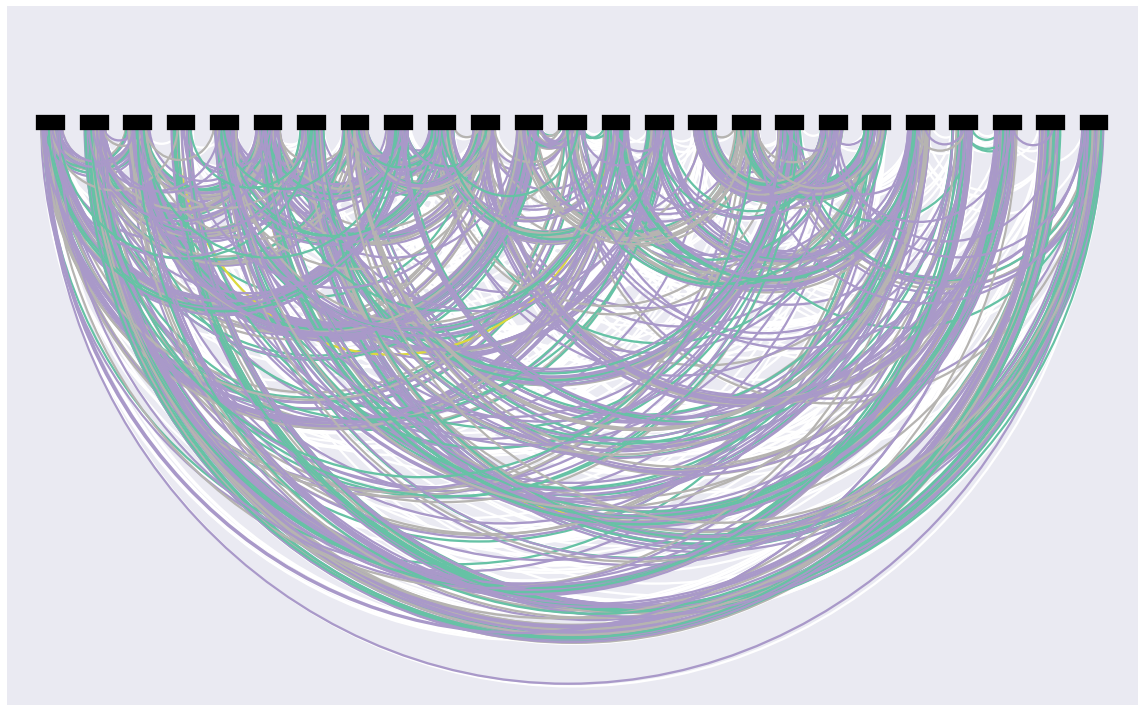

In [193]:
sns.set_style('dark');
figsize(16, 10)
ax = plt.subplot(111, polar=False)

for g in ohnopairs.index:
    try:
        p1, p2 = int(ohnopairs.ix[g].ohnolog_1_chrom), int(ohnopairs.ix[g].ohnolog_2_chrom)
    except ValueError:
        pass
    else:
        p1 += np.random.uniform(-0.25, 0.25)
        p2 += np.random.uniform(-0.25, 0.25)
        center = np.mean((p1, p2))
        radius = np.max((p1, p2)) - center
        w = Wedge((center, 12.5), radius, 180, 360, width=0.05,
                  edgecolor='none',
                  fc=ohno_bin.ix[g, 'color'],
                  lw=1,
                  zorder=(ohno_bin.ix[g, 'category'] != 'Not expressed'),
                 )
        ax.add_patch(w)
        
for i in range(1, 25 + 1):
        wdt = 0.66
        hgt = 0.33
        r = Rectangle((i - wdt / 2, 12.5 - hgt / 2), wdt, hgt, zorder=2, fc='k')
        ax.add_patch(r)
        
#         plt.text(i, 12.5 + hgt, str(i), horizontalalignment='center', verticalalignment='center')

        
plt.xlim(0, 25 + 1)
plt.ylim(0, 13 + 1 + 1);
plt.xticks([])
plt.yticks([]);

plt.tight_layout()
plt.savefig('figures/ohnolog_chromosomes.png')

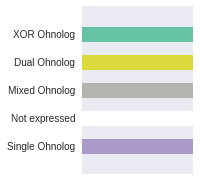

In [140]:
# Make a legend
figsize(2, 3)
plt.subplot(1, 1, 1)

labs = []
locs = []
for i, cat in enumerate(colorer):
    plt.plot([0, 1], [i, i], color=colorer[cat], lw=15)
    locs.append(i)
    labs.append(cat)

plt.ylim(-1, 5);
plt.yticks(locs, labs);
plt.xticks([]);

In [1]:
# Saying something about sequence similarites

In [50]:
import requests

In [51]:
server = "http://rest.ensembl.org"
ext = "/sequence/id/ENSDARG00000075183?"

r = requests.get(server+ext, headers={ "Content-Type" : "text/plain"})

In [52]:
r.headers

{'x-ratelimit-remaining': '54999', 'vary': 'Content-Type', 'x-runtime': '0.336597', 'content-length': '73531', 'connection': 'close', 'x-ratelimit-limit': '55000', 'x-ratelimit-period': '3600', 'date': 'Fri, 08 May 2015 11:33:30 GMT', 'content-type': 'text/plain', 'x-ratelimit-reset': '1590'}

In [53]:
import Levenshtein

In [54]:
def leven_pair(p):
    seqs = []
    for g in p:
        q = "/sequence/id/{}?".format(g)
        r = requests.get(server + q, headers={ "Content-Type" : "text/plain"})
        seqs.append(r.text)
        
    d = Levenshtein.distance(*seqs)
    return (p, d)

In [55]:
leven_pair(('ENSDARG00000035869', 'ENSDARG00000052789'))

(('ENSDARG00000035869', 'ENSDARG00000052789'), 18517)

In [56]:
from joblib import Parallel, delayed

This next step is very slow, don't run

    similarities = Parallel(n_jobs=-1)(delayed(leven_pair)(p) for p in zip(ohnopairs.ohnolog_1,
                                                                           ohnopairs.ohnolog_2))

    fle = open('similiarites.txt', 'w')
    for p in similarities:
        fle.write(p.__repr__() + '\n')

    fle.close()

In [60]:
!head -n 10 similiarites.txt

(('ENSDARG00000075183', 'ENSDARG00000060929'), 99719)
(('ENSDARG00000021936', 'ENSDARG00000075659'), 19019)
(('ENSDARG00000025757', 'ENSDARG00000052027'), 13315)
(('ENSDARG00000009922', 'ENSDARG00000002510'), 4957)
(('ENSDARG00000019596', 'ENSDARG00000062372'), 12672)
(('ENSDARG00000045828', 'ENSDARG00000007737'), 15387)
(('ENSDARG00000012194', 'ENSDARG00000036496'), 100854)
(('ENSDARG00000030155', 'ENSDARG00000058237'), 67552)
(('ENSDARG00000042122', 'ENSDARG00000058229'), 22409)
(('ENSDARG00000063182', 'ENSDARG00000062550'), 24036)


In [61]:
similarities = []
with open('similiarites.txt') as fh:
    for l in fh.readlines():
        similarities.append(eval(l))

In [62]:
similarities[:10]

[(('ENSDARG00000075183', 'ENSDARG00000060929'), 99719),
 (('ENSDARG00000021936', 'ENSDARG00000075659'), 19019),
 (('ENSDARG00000025757', 'ENSDARG00000052027'), 13315),
 (('ENSDARG00000009922', 'ENSDARG00000002510'), 4957),
 (('ENSDARG00000019596', 'ENSDARG00000062372'), 12672),
 (('ENSDARG00000045828', 'ENSDARG00000007737'), 15387),
 (('ENSDARG00000012194', 'ENSDARG00000036496'), 100854),
 (('ENSDARG00000030155', 'ENSDARG00000058237'), 67552),
 (('ENSDARG00000042122', 'ENSDARG00000058229'), 22409),
 (('ENSDARG00000063182', 'ENSDARG00000062550'), 24036)]

In [63]:
['ENSDARG00000009087', 'ENSDARG00000036628'] 
g = 'ENSDARG00000009087'
q = "/sequence/id/{}?expand_5prime=1000".format(g)
r = requests.get(server + q, headers={ "Content-Type" : "text/plain"})

p1 = r.text[:1000]

g = 'ENSDARG00000036628'
q = "/sequence/id/{}?expand_5prime=1000".format(g)
r = requests.get(server + q, headers={ "Content-Type" : "text/plain"})

p2 = r.text[:1000]

In [64]:
p1

u'GTCAGTGGTCCATATAGATGAAAATTTCACTTCACCTTTGATATTTGGAAGTGACGGTGTGTCACAGTGGAGTTTTGCGAACTTGATTCTTTTTTCAGTTCTGTGTTTTAGGAAGAACAACATGTTTCTTTAAAAGGAATAAGTTTTCTCTGTGGTGTCCAATCAGAGAGCACGAATCATTGGTTTCTTGGCAGAACTTGCGCTAATTTACTCATATTTTATCATGTTTATGTTTTTAACTCCACGTAATGTCACTTACAATCATTACCAATGCTATAATGTAAAACTTTATAATTGTATTAGACTATTAAAGTCATAAGAAATATAATGCACATTTAAAAAGGCATGACACAAAACAGAGATATCACTTTCACTTACATCCCGAATGCATAATGCCTATGTTTATAACTAATTAATACCCTTTTTAATGTCATCATGTTACTTACAAAGACCTTAATAGCTATATAGTGAAATTTATATTAATATTATGCATGTAAAGTTTAATATAAAATATACATTTAACAAGATAAGACTCAAACTTTCACTTAAATTACCTCAGGAATGCAAAATGCCTGTACTTATAGCTAATTAATACCCTTTTTATAACATCATGTTACTTACAACCATTTAAATAGCTATTGTGTACAAGTTTAAAGTCCTATTATGTACATAAAGTGTAATACTGTATTACTAATGTACATTTAAAAAGATAAGACACAAGCTTTCACTTAAATTACCTCACGAATGCATAACAAAGGCCTATATGTGTATAGCGATTTAATTCACGTTTATAAGAAGCATTTATATGAATATATTCGACATATTTGTGTAGATATTTCCTATTTTTGTTTAAAATTAAAGGATTAATTGTGATATTTACTTCCCCTGTGTTCAGTGAACCACTTTCGATAGTAACACGATGGTCGAAGTTTGAGTCTCTCCATCAACTGATGACGTTTTACTCGCCAGCCAATCAGATTTGAGAAATGCAGACGCGA

In [65]:
p2

u'TAAGATGATTGATCATGTCTAACCGGTTTATTGTTAATGTGAAACTTCTTCTGAAACCAAATGGACACTAGGGGAATACCAAGAAAACATCCTCATTGAGATCAAGCCTGAATTATTCATTTCCTCTTTGTAGAAAGTGTTTTGACCTTCACAAATGCTGGTGTTAAAATCTTTTTTTTTTTCTGCTGGTAATTTAGCGAATTGAATGCAAACAATTAGCAAAATATTGTATTGAGACAAAATAAAAGATAAAAATCAGACTCTAGTTTAAGGCCGCATTAAACAATGGTAAATATTGTCATCTCTTCTTTAGGGGCGTTTACACAACCCACTGCTTGATTCTGACCATTTATTTACTGCTTTTAAAGTAGCATCGCCTATTAAGCAAAACTTAAAGTAAAAAATGTACTCGCATATTTAATAGTGCTGTTTCTTTAGTAGTTTATTTCATAAAGTCATAAAGTTGTCTTGTTTCGGATTGAGCATGGTTTGCTTTGTAAAATGGAACTGAAAGGAAAAGCATCATAAAATAGGCCTCCATTCTAAACAATAGGAGAGTTTAATTTCTTTCTGCAAGTTAAAAGGCAATTCTCAGTTGAAATACTTTTTGTGAAGCTTTTTGACAGTAAAATTTTACTTGAAGCTTTGCATTTTTAGTCTTTAAACAAGTAATAAAATGTTTACATTTTCAGTGGTGATTGTGACCTTAAAGAGCATCTTTTATAATGAGTCACTGTCTATCACTTTAATGAACACCGGCGAATATCAAAGTAGCCTCTCTATTGTGTTGGAAAACTCAAAACCGAAAATGACTGACAAAAACATTGTTAAAGTTCAAGAAAGTACTTTGTAATTTTCACTCGGTATGCGTTTAGGAATAGGCGAGAGATGTGAACGAGCGCTTTCAACTCTACTGTTGTCTGACAACTGATGACGCAGCCCGCCTCATCCAATCAATAATCGCTAAAGTCGAGCTTTCTGCAGTGAGTCTCTTCACT

In [66]:
Levenshtein.distance(p1, p2)

502

In [67]:
sim_dict = {}
for t in similarities:
    sim_dict[t[0][0]] = t[1]

In [68]:
sim_series = pd.Series(sim_dict)

In [69]:
ohno_sim = sim_series[ohno_corr.index]

In [70]:
idx = ohno_corr[ohno_corr > 0.1].index

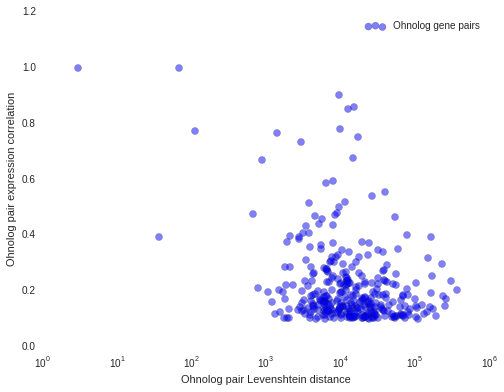

In [71]:
figsize(8, 6)
plt.scatter(ohno_sim.ix[idx] + 1, ohno_corr.ix[idx], s=50, alpha=0.5, label='Ohnolog gene pairs');
plt.xscale('log');
sns.axlabel('Ohnolog pair Levenshtein distance', 'Ohnolog pair expression correlation')
plt.legend(scatterpoints=3);

In [72]:
stats.spearmanr(ohno_sim.ix[idx], ohno_corr.ix[idx])

(-0.20120135285246915, 0.00024486125320662361)

In [73]:
gene_annotation[gene_annotation['Associated Gene Name'] == 'znf292b']

,Associated Gene Name,Chromosome Name,Gene Start (bp),Gene End (bp),Gene Biotype,Transcript count
0,,,,,,
ENSDARG00000043973,znf292b,20,217311,232690,protein_coding,1


In [226]:
ohnopairs.ix['ENSDARG00000043973']

ohnolog_1_chrom                    20
ohnolog_1          ENSDARG00000043973
ohnolog_2_chrom                    17
ohnolog_2          ENSDARG00000016763
Name: ENSDARG00000043973, dtype: object

In [75]:
ohno_bin.ix['ENSDARG00000043973']

c00    271
c01     47
c10     45
c11     10
Name: ENSDARG00000043973, dtype: int64

In [ ]:
sim_series.ix['ENSDARG00000043973']

In [ ]:
['ENSDARG00000043973', 'ENSDARG00000016763'] 
g = 'ENSDARG00000043973'
q = "/sequence/id/{}?expand_5prime=1000".format(g)
r = requests.get(server + q, headers={ "Content-Type" : "text/plain"})

p1 = r.text[:1000]

g = 'ENSDARG00000016763'
q = "/sequence/id/{}?expand_5prime=1000".format(g)
r = requests.get(server + q, headers={ "Content-Type" : "text/plain"})

p2 = r.text[:1000]

In [ ]:
p1

In [ ]:
p2

In [ ]:
Levenshtein.distance(p1, p2)

In [ ]:
r = requests.get(server + q, headers={ "Content-Type" : "text/plain"})

In [ ]:
r.headers

In [ ]:
def leven_pair_promotor(p):
    seqs = []
    for g in p:
        q = "/sequence/id/{}?expand_5prime=1000".format(g)
        r = requests.get(server + q, headers={ "Content-Type" : "text/plain"})
        print r.ok, r.reason
        seqs.append(r.text[:1000])
        
    d = Levenshtein.distance(*seqs)
    return (p, d)

In [ ]:
leven_pair_promotor(['ENSDARG00000043973', 'ENSDARG00000016763'])

In [ ]:
from multiprocessing import Pool

In [ ]:
pool = Pool(processes=16)

In [ ]:
leven_pair_promotor(('ENSDARG00000021140', 'ENSDARG00000017219'))

In [ ]:
map(leven_pair_promotor, zip(ohnopairs.ohnolog_1, ohnopairs.ohnolog_2)[:40])

In [ ]:
%%time
pool.map(leven_pair_promotor, zip(ohnopairs.ohnolog_1, ohnopairs.ohnolog_2)[:40])

In [ ]:
promotor_similarities = Parallel(n_jobs=2)(delayed(leven_pair_promotor)(p) for p in zip(ohnopairs.ohnolog_1, ohnopairs.ohnolog_2)[:40])